In [2]:
import numpy as np
from matplotlib import pyplot as plt
from plot_config import PlotConfig
import bgp_qnm_fits as bgp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FixedLocator

ID = '0001'
DATA_TYPE = 'news'
SPHERICAL_MODES = [(2,2), (3,2), (4,4)] 
THRESHOLD = 0.99
N_MAX = 6
T = 100
N_DRAWS = 1000
INCLUDE_CHIF = True
INCLUDE_MF = True

t0_vals = np.arange(0, 50.1, 4)

sim = bgp.SXS_CCE(ID, type=DATA_TYPE, lev="Lev5", radius="R2")
tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[ID]
Mf, chif = sim.Mf, sim.chif_mag

log_threshold = np.log(THRESHOLD)
initial_modes = [(*s, 0, -1 if s[1] < 0 else 1) for s in SPHERICAL_MODES]
candidate_modes = [(*s, n, -1 if s[1] < 0 else 1) for s in SPHERICAL_MODES for n in range(1, N_MAX+1)] + [(2,2,0,1,2,2,0,1)]

/data/vault/rvnd2/Code/qnmfits/qnmfits/Waveforms/Base.py:116: RuntimeWarning: divide by zero encountered in divide
  chidot = self.Jdot/(self.Moft**2).reshape(len(self.Moft),1)


In [18]:
full_modes_list = [] 

for i, t0 in enumerate(t0_vals):
    print(f'Fitting from {t0=}')
    select_object = bgp.BGP_select(
        sim.times,
        sim.h,
        initial_modes,
        Mf,
        chif,
        tuned_param_dict_GP,
        bgp.kernel_GP,
        t0=t0,
        candidate_modes=candidate_modes,
        log_threshold=log_threshold,
        num_draws=N_DRAWS,
        T=T,
        spherical_modes=SPHERICAL_MODES,
        include_chif=INCLUDE_CHIF,
        include_Mf=INCLUDE_MF,
        data_type=DATA_TYPE
    )

    full_modes_list.append(select_object.full_modes)


Fitting from t0=0.0
Adding mode (2, 2, 1, 1) with significance 1.0.
Adding mode (2, 2, 2, 1) with significance 1.0.
Adding mode (2, 2, 3, 1) with significance 1.0.
Adding mode (2, 2, 4, 1) with significance 1.0.
Adding mode (2, 2, 5, 1) with significance 1.0.
Adding mode (2, 2, 6, 1) with significance 1.0.
Adding mode (3, 2, 1, 1) with significance 1.0.
Adding mode (3, 2, 2, 1) with significance 1.0.
Adding mode (3, 2, 3, 1) with significance 1.0.
Adding mode (3, 2, 4, 1) with significance 1.0.
Adding mode (3, 2, 5, 1) with significance 1.0.
Adding mode (3, 2, 6, 1) with significance 1.0.
Adding mode (4, 4, 1, 1) with significance 1.0.
Adding mode (4, 4, 2, 1) with significance 1.0.
Adding mode (4, 4, 3, 1) with significance 1.0.
Adding mode (4, 4, 4, 1) with significance 1.0.
Adding mode (4, 4, 5, 1) with significance 1.0.
Adding mode (4, 4, 6, 1) with significance 1.0.
Adding mode (2, 2, 0, 1, 2, 2, 0, 1) with significance 1.0.
Stopping: no more modes to add.
Final mode content [(2, 

In [19]:
def masks(mode, full_modes_list):
    # Original mask
    mask = np.array([mode in full_modes_list[i] for i, t0 in enumerate(t0_vals)])

    # Step 1: Identify changes
    changes = np.diff(mask.astype(int)) 

    # Step 2: Start and end indices
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0] + 1

    # Handle edge case: mask starts or ends with True
    if mask[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if mask[-1]:
        end_indices = np.append(end_indices, len(mask))

    # Step 3: Extract each run into a list of masks
    true_runs = []
    for start, end in zip(start_indices, end_indices):
        run_mask = np.zeros_like(mask, dtype=bool)
        run_mask[start:end] = True
        true_runs.append(run_mask)

    return true_runs

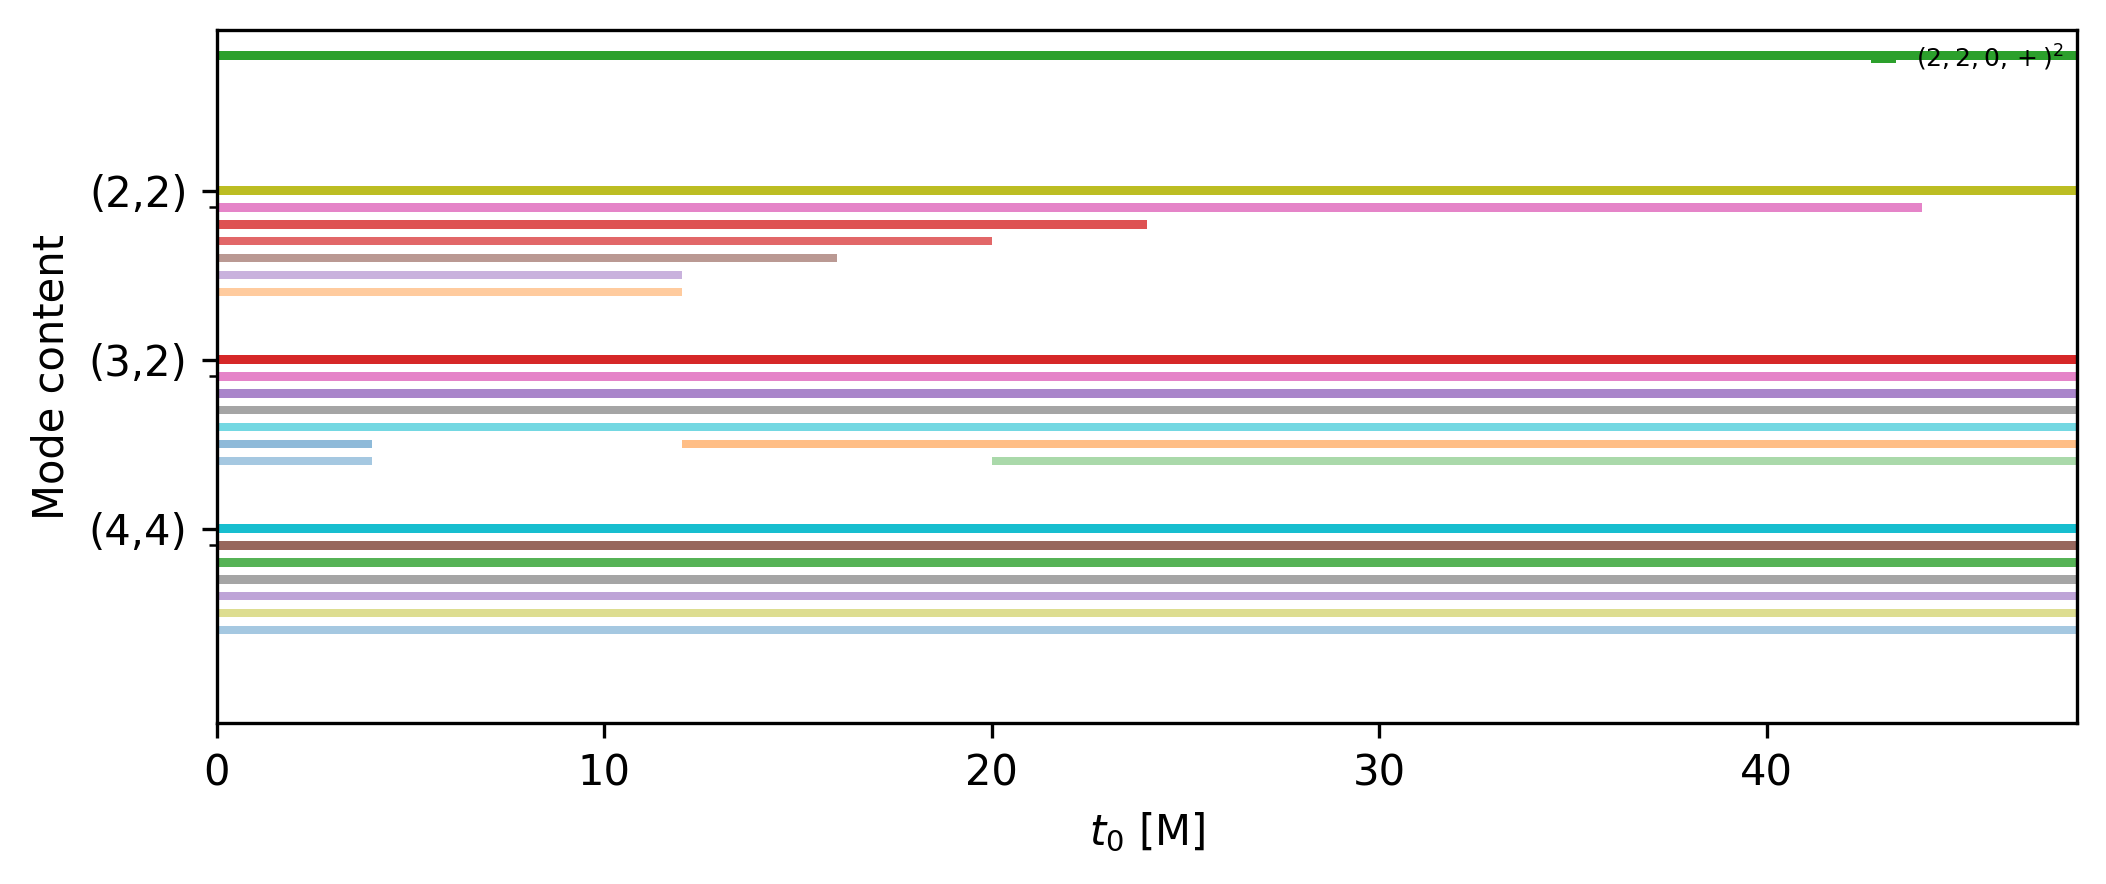

In [20]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

y_tick_len =len(SPHERICAL_MODES)

eps = 0.25

l_max = 0
n_max = 0

lm_y_pos = [-i * 10 for i in range(y_tick_len)]

all_modes = list({mode for mode in candidate_modes + initial_modes})
for mode in all_modes:
    if len(mode) == 4:
        l, m, n, p = mode
        y_pos = lm_y_pos[SPHERICAL_MODES.index((l, m))]
        y = y_pos - n
    elif len(mode) == 8:
        l, m, n, p, lp, mp, nprime, pp = mode
        y = 8
    elif len(mode) == 12:
        l, m, n, p, lp, mp, nprime, pp, lpp, mpp, npp, ppp = mode
        y = 4

    l_max = max(l_max, l)
    n_max = max(n_max, n)

    runs = masks(mode, full_modes_list)
    for i, run in enumerate(runs):
        label = None
        if i == 0:
            label = (None if len(mode) == 4 else (r"$(2,2,0,+)^2$" if len(mode) == 8 else r"$(2,2,0,+)^3$"))
        ax.fill_between(
            t0_vals[run],
            [y-eps for t0 in t0_vals[run]],
            [y-1+eps for t0 in t0_vals[run]],
            alpha=1-0.1*n if len(mode) == 4 else 1,
            #color=(colors[l-2] if len(mode) == 4 else (colors[5] if len(mode) == 8 else colors[6])),
            label=label
        )
        
ax.set_xlabel(r"$t_0$ [M]")
ax.set_ylabel(r"Mode content")

ax.set_xlim(0, t0_vals[-1])
ax.set_ylim(-(y_tick_len - 1) * 12 - n_max - 2, 9)

ticks = [lm_y_pos[i] - 0.5 for i in range(y_tick_len)]
tick_labels = [f"({l},{m})" for (l, m) in SPHERICAL_MODES]
minor_ticks = [tick - 1 for tick in ticks]

ax.set_yticks(ticks)
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))
ax.set_yticklabels(tick_labels)

ax.legend(loc='upper right', frameon=False, fontsize=6,
          bbox_to_anchor=(1., 1.), handlelength=1., handleheight=0.3,
          borderpad=0., labelspacing=0.5, ncol=2)

plt.show()
